In [83]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from custom_loss import custom_loss_function
# import custom_metric

In [85]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics
import datetime as dt
from tensorflow.keras import models

In [86]:
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Data creation and clean

In [87]:
# import data and check columns
df = pd.read_csv('../raw_data/final_df.csv')
df.columns

Index(['meeting_id', 'meeting_name', 'date', 'country_code', 'event_number',
       'distance', 'distance_unit', 'distance_furlongs',
       'distance_raw_furlongs', 'race_class',
       ...
       '10 mins', '5 mins', '3 mins', '2 mins', '1 min ', 'Post Time',
       'Last Traded Price', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max'],
      dtype='object', length=140)

In [88]:
#testing pipeline
from pipeline_cleaning import clean_data, transforming_data
df_clean= clean_data(df.copy())
df_transform = transforming_data(df_clean.copy())

drop done
step two
Cleaned the data


In [89]:
pd.DataFrame(df_transform[0]).columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [90]:
train = df_transform[0]
val = df_transform[1]
test = df_transform[2]

In [91]:
X_train = train.drop(columns = ['meeting_id', 'horse_id','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1)
X_val = val.drop(columns = ['meeting_id', 'horse_id','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1)
X_test = test.drop(columns = ['meeting_id', 'horse_id','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1 )

In [92]:
X_train.shape, X_val.shape, X_test.shape

((73401, 67), (56804, 67), (40350, 67))

In [95]:
X_train.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [96]:
y_train = np.array(train[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))
y_val = np.array(val[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))
y_test = np.array(test[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))

In [97]:
test[['win_or_lose']].replace({'win_or_lose':0.5}, 1.0).value_counts()

win_or_lose
0.0            35788
1.0             4562
Name: count, dtype: int64

# Model - Custom Loss Softmax

In [98]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.Accuracy(name='accuracy'),
    # keras.metrics.F1Score(name='f1_score')
    # keras.metrics.F1   # precision-recall curve add precsion, F1, accuracy
    
]
#change to mse, mae, rmse

In [189]:
#build model
def inititialize_model_softmax(X_train):

    #architecture
#   normaliser = Normalization() -suggestion to do normalization on target (y)
    model = models.Sequential()
    model.add(layers.Dense(1000, activation = 'relu', input_dim=X_train.shape[-1]))
    model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(500, activation = 'relu'))
    # model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(100, activation = 'relu'))
    # model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(2, activation = 'softmax'))
    
    # classification comilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss=custom_loss_function,
              optimizer=optimizer, 
              metrics=metrics)
    return model

In [190]:
#initialize model
model_softmax = inititialize_model_softmax(X_train)
model_softmax.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              68000     
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 dense_9 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 70,002
Trainable params: 70,002
Non-trainable params: 0
_________________________________________________________________


In [101]:
X_train.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [102]:
# Earlystopping to prevent overfitting using the vlidation data set
es = EarlyStopping(patience=3, monitor="val_loss")
# Train the model
history = model_softmax.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs=15, #increase number of epochs
                    batch_size=32, 
                    callbacks=[es])

Epoch 1/15
2294/2294 [==============================] - 8s 3ms/step - loss: -0.0676 - recall: 0.8560 - precision: 0.9499 - prc: 0.9363 - accuracy: 0.0000e+00 - val_loss: -0.0788 - val_recall: 0.8634 - val_precision: 0.9610 - val_prc: 0.9352 - val_accuracy: 0.0000e+00
Epoch 2/15
2294/2294 [==============================] - 7s 3ms/step - loss: -0.0793 - recall: 0.8682 - precision: 0.9635 - prc: 0.9387 - accuracy: 0.0000e+00 - val_loss: -0.0799 - val_recall: 0.8629 - val_precision: 0.9604 - val_prc: 0.9353 - val_accuracy: 0.0000e+00
Epoch 3/15
2294/2294 [==============================] - 7s 3ms/step - loss: -0.0797 - recall: 0.8684 - precision: 0.9637 - prc: 0.9401 - accuracy: 0.0000e+00 - val_loss: -0.0799 - val_recall: 0.8644 - val_precision: 0.9621 - val_prc: 0.9391 - val_accuracy: 0.0000e+00
Epoch 4/15
2294/2294 [==============================] - 7s 3ms/step - loss: -0.0800 - recall: 0.8687 - precision: 0.9640 - prc: 0.9403 - accuracy: 0.0000e+00 - val_loss: -0.0805 - val_recall: 0.86

In [103]:
y_test_pred = model_softmax.predict(X_test, verbose=0)

In [104]:
#left is the off of winning and left is showing the betting odds
#the model is showing how to minimise your losses
y_test_pred

array([[9.9999994e-01, 1.8767025e-08],
       [2.0560423e-08, 9.9999994e-01],
       [1.6492057e-05, 9.9998349e-01],
       ...,
       [9.9981362e-01, 1.8636415e-04],
       [2.2094495e-08, 1.0000000e+00],
       [9.5809742e-07, 9.9999905e-01]], dtype=float32)

In [105]:
#make all draws into 1 i.e. wins because it means that two horses won and view dataframe

results_df = pd.DataFrame({'y_pred': y_test_pred.round(2)[:,0], 'y_true': test['win_or_lose'].replace(0.5, 1.0)})
results_df

,y_pred,y_true
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
40345,0.0,0.0
40346,0.0,0.0
40347,1.0,1.0
40348,0.0,0.0


In [106]:
#take a look at the number of losses vs the number of wins to sense check
results_df.y_true.value_counts()

y_true
0.0    35788
1.0     4562
Name: count, dtype: int64

In [107]:
#figures
loss = results_df.y_true.value_counts()[0]
win = results_df.y_true.value_counts()[1]

In [108]:
# percentages
round(loss/(loss+win)*100,0)
round(win/(loss+win)*100,0)

11.0

In [109]:
results_df['y_pred_050'] = results_df.y_pred.map(lambda x: 1.0 if x>=0.5 else 0.0)
results_df.y_pred_050.value_counts()

y_pred_050
0.0    34331
1.0     6019
Name: count, dtype: int64

In [111]:
results_df

,y_pred,y_true,y_pred_050
0,1.0,1.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
40345,0.0,0.0,0.0
40346,0.0,0.0,0.0
40347,1.0,1.0,1.0
40348,0.0,0.0,0.0


In [60]:
#the model isn't for sure able to say of win or loss as shown in the diagram below so we will set thresholds to force the model results to be returned as a win or loss depending on the thresholds
results_df.y_pred.value_counts()

y_pred
0.00    33995
1.00     5518
0.99      171
0.01      104
0.98       59
        ...  
0.49        1
0.45        1
0.15        1
0.34        1
0.63        1
Name: count, Length: 95, dtype: int64

<Axes: xlabel='y_true', ylabel='Count'>

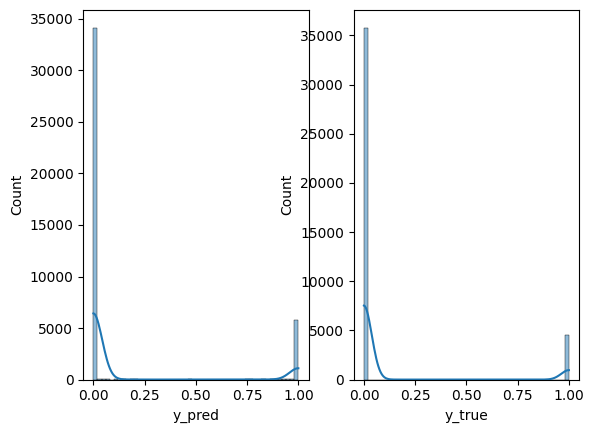

In [112]:
#more wins have been predicted
plt.subplot(1, 2, 1)
sns.histplot(results_df.y_pred, bins= 50, kde =True)
plt.subplot(1, 2, 2)
sns.histplot(results_df.y_true, bins= 50, kde =True)

In [113]:
#high acuracy - potentially two high, high percision suggests we have high quality data, F1-score = high precision and recall consistantly, accuracy_score is accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
scores = {
    'accuracy': [accuracy_score(results_df.y_true, results_df.y_pred_050)],
    'precision': [precision_score(results_df.y_true, results_df.y_pred_050)],
    'recall': [recall_score(results_df.y_true, results_df.y_pred_050)],
    'f1': [f1_score(results_df.y_true, results_df.y_pred_050)]
}
scores_df = pd.DataFrame(scores)
scores_df

,accuracy,precision,recall,f1
0,0.961809,0.750955,0.990794,0.854362


In [114]:
#evaluate model shows a very low loss metric
model_softmax.evaluate(X_test, y_test)

1261/1261 [==============================] - 2s 1ms/step - loss: -0.0816 - recall: 0.8651 - precision: 0.9629 - prc: 0.9379 - accuracy: 0.0000e+00


[-0.0816466435790062,
 0.8650694489479065,
 0.9628748297691345,
 0.9378529191017151,
 0.0]

In [115]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.title('Model Accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='best')
    # plt.show()

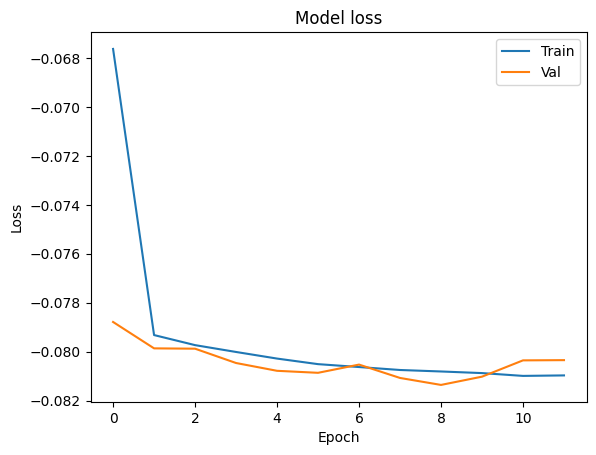

In [116]:
plot_loss_accuracy(history)

In [117]:
#the sum of the amount that could be won based on the odds 1min before the race
sum(results_df.y_pred*test['1_min_'])

59911.36672410178

In [122]:
#creation of unique values column and inclusion of y_pred column for the prediction of profit using the model
test_results_df = test.copy()[['meeting_id', 'event_number',
       'place', 
       #'15_mins', '10_mins', '5_mins', '3_mins', '2_mins',
       '1_min_', 'win_or_lose']]

In [124]:
test_results_df['race_id'] = test_results_df['meeting_id'].astype(str) + '_' + test_results_df['event_number'].astype(str)
test_results_df['y_pred'] = results_df['y_pred']

In [135]:
#set bet thresholds i.e. betting thresholds 50%, 75%, 80%, 90% and 95% - don't bet if less than 50%
test_results_df['bet'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.5 else 0.0)
test_results_df['bet_075'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.75 else 0.0)
test_results_df['bet_080'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.80 else 0.0)
test_results_df['bet_090'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.90 else 0.0)
test_results_df['bet_095'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.95 else 0.0)


In [139]:
#show different profit - cost
test_results_df['profit_050'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet']


In [140]:
test_results_df['profit_075'] = test_results_df['profit_050']*test_results_df['bet_075']
test_results_df['profit_080'] = test_results_df['profit_050']*test_results_df['bet_080']
test_results_df['profit_090'] = test_results_df['profit_050']*test_results_df['bet_090']
test_results_df['profit_095'] = test_results_df['profit_050']*test_results_df['bet_095']
test_results_df = test_results_df.sort_values(by='race_id')

In [141]:
#show final test resulta dataframe
test_results_df

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,bet_090,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095
8555,35179.0,7.0,3.0,4.7,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
22589,35179.0,7.0,2.0,4.5,0.0,35179.0_7.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
12897,35179.0,7.0,9.0,340.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
9587,35179.0,7.0,10.0,20.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
17586,35179.0,7.0,8.0,70.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,37729.0,6.0,10.0,60.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
30892,37729.0,6.0,9.0,7.2,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
21245,37729.0,6.0,5.0,40.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6477,37729.0,6.0,6.0,90.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [206]:
test_results_df.profit_095.value_counts()

profit_095
-0.00     34499
-1.00      1360
 5.20        93
 9.50        75
 9.00        75
          ...  
 0.01         1
 47.00        1
 1.75         1
 5.50         1
 0.43         1
Name: count, Length: 268, dtype: int64

In [143]:
#number of wins based on random bets
random_bet = []
for race in sorted(set(test_results_df.race_id)):
    n_runners = test_results_df.race_id.value_counts()[race]
    ls = list(np.zeros(n_runners))
    ls[np.random.randint(0, n_runners)] = 1.0
    random_bet+=ls
random_bet

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0

In [152]:
#number of wins and losses when looking at the best odds
best_odds_bet = []
for race in sorted(set(test_results_df.race_id)):
    sub_df = test_results_df[test_results_df.race_id==race].reset_index() 
    odds_ls = list(sub_df['1_min_'])
    n_runners = len(sub_df)
    ls = list(np.zeros(n_runners))
    ls[odds_ls.index(min(odds_ls))] = 1.0
    best_odds_bet+=ls
best_odds_bet

[0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0

In [153]:
test_results_df[test_results_df.race_id==race]

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,bet_090,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095
39163,37729.0,6.0,4.0,8.6,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2490,37729.0,6.0,2.0,10.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1902,37729.0,6.0,7.0,7.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
15998,37729.0,6.0,3.0,5.6,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5673,37729.0,6.0,1.0,6.8,1.0,37729.0_6.0,1.0,1.0,1.0,1.0,1.0,1.0,5.8,5.8,5.8,5.8,5.8
5977,37729.0,6.0,10.0,60.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
30892,37729.0,6.0,9.0,7.2,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
21245,37729.0,6.0,5.0,40.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6477,37729.0,6.0,6.0,90.0,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1967,37729.0,6.0,8.0,7.4,0.0,37729.0_6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [155]:
test_results_df['bet_random'] = random_bet
test_results_df['profit_random'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet_random']
test_results_df['bet_best_odds'] = best_odds_bet
test_results_df['profit_best_odds'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet_best_odds']

In [156]:
X_train.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [157]:
test_results_df.head(50)

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
8555,35179.0,7.0,3.0,4.70,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,1.0,-1.0,0.0,-0.00
22589,35179.0,7.0,2.0,4.50,0.0,35179.0_7.0,1.0,1.0,1.0,1.0,...,1.0,-1.00,-1.00,-1.00,-1.00,-1.00,0.0,-0.0,1.0,-1.00
12897,35179.0,7.0,9.0,340.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
9587,35179.0,7.0,10.0,20.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
17586,35179.0,7.0,8.0,70.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
27302,35179.0,7.0,13.0,9.60,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
8212,35179.0,7.0,5.0,190.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
24315,35179.0,7.0,4.0,10.50,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
9849,35179.0,7.0,6.0,36.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
12016,35179.0,7.0,11.0,220.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00


In [158]:
test_results_df[(test_results_df.win_or_lose==0.0)&(test_results_df.bet_080==0.0 )&(test_results_df.bet==1.0 )]

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
4310,35196.0,5.0,3.0,3.70,0.0,35196.0_5.0,0.78,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
9199,35453.0,1.0,2.0,3.60,0.0,35453.0_1.0,0.79,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
3795,35453.0,7.0,3.0,9.60,0.0,35453.0_7.0,0.75,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
38133,35496.0,4.0,2.0,3.30,0.0,35496.0_4.0,0.69,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
18421,35531.0,7.0,3.0,16.00,0.0,35531.0_7.0,0.79,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
17807,35579.0,6.0,2.0,3.15,0.0,35579.0_6.0,0.71,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
14236,35610.0,7.0,2.0,17.00,0.0,35610.0_7.0,0.65,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
38503,35641.0,5.0,5.0,10.00,0.0,35641.0_5.0,0.79,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
10139,35660.0,2.0,2.0,6.00,0.0,35660.0_2.0,0.53,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
24793,35661.0,8.0,2.0,5.20,0.0,35661.0_8.0,0.57,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0


In [212]:
#filter on one unique column
test_results_df[test_results_df.race_id=='37622.0_1.0']

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
240,37622.0,1.0,6.0,13.5,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
9258,37622.0,1.0,1.0,13.5,1.0,37622.0_1.0,1.00,1.0,1.0,1.0,...,1.0,12.5,12.5,12.5,12.5,12.5,0.0,0.0,0.0,0.0
39698,37622.0,1.0,5.0,4.3,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
32725,37622.0,1.0,10.0,260.0,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
14947,37622.0,1.0,8.0,19.5,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
4060,37622.0,1.0,3.0,21.0,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
12397,37622.0,1.0,2.0,5.1,0.0,37622.0_1.0,0.58,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
29500,37622.0,1.0,4.0,7.6,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
36428,37622.0,1.0,7.0,5.5,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
35010,37622.0,1.0,9.0,75.0,0.0,37622.0_1.0,0.00,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-1.0,0.0,-0.0


In [210]:
test_results_df[test_results_df['race_id'] == "35179.0_7.0"]

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
8555,35179.0,7.0,3.0,4.7,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-1.0,0.0,-0.0
22589,35179.0,7.0,2.0,4.5,0.0,35179.0_7.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-0.0,1.0,-1.0
12897,35179.0,7.0,9.0,340.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
9587,35179.0,7.0,10.0,20.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
17586,35179.0,7.0,8.0,70.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
27302,35179.0,7.0,13.0,9.6,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
8212,35179.0,7.0,5.0,190.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
24315,35179.0,7.0,4.0,10.5,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
9849,35179.0,7.0,6.0,36.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
12016,35179.0,7.0,11.0,220.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0


In [162]:
#summarise the total amount of loss
race_results = test_results_df.groupby(by='race_id', as_index=False).sum()
race_results

,race_id,meeting_id,event_number,place,1_min_,win_or_lose,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
0,35179.0_7.0,492506.0,98.0,105.0,998.30,1.0,2.00,2.0,2.0,2.0,...,2.0,11.00,11.00,11.00,11.00,11.00,1.0,-1.0,1.0,-1.00
1,35180.0_7.0,281440.0,56.0,127.0,239.20,1.0,1.00,1.0,1.0,1.0,...,1.0,0.70,0.70,0.70,0.70,0.70,1.0,-1.0,1.0,0.70
2,35184.0_1.0,316656.0,9.0,45.0,135.64,1.0,1.00,1.0,1.0,1.0,...,1.0,1.84,1.84,1.84,1.84,1.84,1.0,-1.0,1.0,1.84
3,35184.0_2.0,351840.0,20.0,55.0,1181.79,1.0,1.00,1.0,1.0,1.0,...,1.0,0.89,0.89,0.89,0.89,0.89,1.0,-1.0,1.0,0.89
4,35184.0_3.0,387024.0,33.0,66.0,247.80,1.0,1.00,1.0,1.0,1.0,...,1.0,6.60,6.60,6.60,6.60,6.60,1.0,6.6,1.0,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,37729.0_2.0,415019.0,22.0,66.0,2211.81,1.0,2.00,2.0,2.0,2.0,...,2.0,-0.49,-0.49,-0.49,-0.49,-0.49,1.0,-1.0,1.0,0.51
4557,37729.0_3.0,415019.0,33.0,66.0,436.60,1.0,1.00,1.0,1.0,1.0,...,1.0,2.70,2.70,2.70,2.70,2.70,1.0,-1.0,1.0,2.70
4558,37729.0_4.0,301832.0,32.0,36.0,84.80,1.0,1.00,1.0,1.0,1.0,...,1.0,4.50,4.50,4.50,4.50,4.50,1.0,-1.0,1.0,-1.00
4559,37729.0_5.0,339561.0,45.0,45.0,132.35,1.0,1.85,2.0,2.0,2.0,...,1.0,17.50,17.50,17.50,18.50,18.50,1.0,-1.0,1.0,-1.00


In [164]:
race_results.columns

Index(['race_id', 'meeting_id', 'event_number', 'place', '1_min_',
       'win_or_lose', 'y_pred', 'bet', 'bet_075', 'bet_080', 'bet_090',
       'bet_095', 'profit_050', 'profit_075', 'profit_080', 'profit_090',
       'profit_095', 'bet_random', 'profit_random', 'bet_best_odds',
       'profit_best_odds'],
      dtype='object')

In [165]:
profit_trend_df = race_results[['profit_050', 'profit_075', 'profit_080', 'profit_090', 'profit_095', 'profit_random', 'profit_best_odds']].cumsum()
profit_trend_df

,profit_050,profit_075,profit_080,profit_090,profit_095,profit_random,profit_best_odds
0,11.000,11.000,11.000,11.000,11.000,-1.000,-1.00
1,11.700,11.700,11.700,11.700,11.700,-2.000,-0.30
2,13.540,13.540,13.540,13.540,13.540,-3.000,1.54
3,14.430,14.430,14.430,14.430,14.430,-4.000,2.43
4,21.030,21.030,21.030,21.030,21.030,2.600,1.43
...,...,...,...,...,...,...,...
4556,32966.735,32743.235,32756.335,32348.425,32100.325,182.145,-36.16
4557,32969.435,32745.935,32759.035,32351.125,32103.025,181.145,-33.46
4558,32973.935,32750.435,32763.535,32355.625,32107.525,180.145,-34.46
4559,32991.435,32767.935,32781.035,32374.125,32126.025,179.145,-35.46


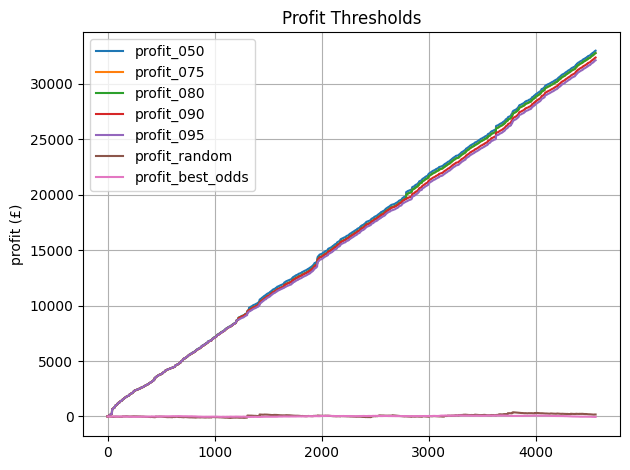

In [215]:
#showing different profit lines 
profit_trend_df.plot(kind='line')
plt.title("Profit Thresholds")
# plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#will check model further as output seems to be perfect - too good to be true - potential data leakage

In [202]:
'profit_075'.cumsum()

# over08['cumulative_profit'] = over08['linear_target'].cumsum()

# over09['cumulative_profit'] = over09['linear_target'].cumsum()

# over095['cumulative_profit'] = over095['linear_target'].cumsum()

AttributeError: 'str' object has no attribute 'cumsum'

ValueError: 'profit_075' is not a valid format string (two marker symbols)

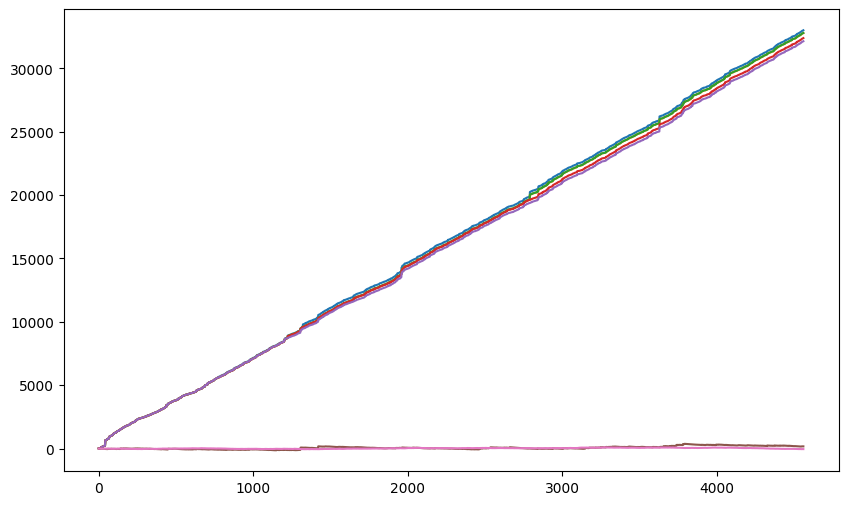

In [201]:
# Plot

plt.figure(figsize=(10,6))
plt.plot(range(1, len(profit_trend_df) + 1), profit_trend_df, label='confidence > 0.5')
plt.plot(range(1, len('profit_075') + 1), 'profit_075', label='confidence > 0.75')
plt.plot(range(1, len('profit_080') + 1), 'profit_080', label='confidence > 0.8')
plt.plot(range(1, len('profit_090') + 1), 'profit_090', label='confidence > 0.9')
plt.plot(range(1, len('profit_095') + 1), 'profit_095', label='confidence > 0.95')
plt.plot(range(1, len('profit_random') + 1), 'profit_random', label='random bets')
plt.plot(range(1, len('profit_best_odds') + 1), 'profit_best_odds', label='best odds')

# plt.plot(range(1, len(less2) + 1), less2['cumulative_profit'], label='<2 odds')
# plt.plot(range(1, len(odd_2_5) + 1), odd_2_5['cumulative_profit'], label='2-5 odds')
# plt.plot(range(1, len(odd_5_10) + 1), odd_5_10['cumulative_profit'], label='5-10 odds')
# plt.plot(range(1, len(odd_10_25) + 1), odd_10_25['cumulative_profit'], label='10-25 odds')
# plt.plot(range(1, len(odd_25_50) + 1), odd_25_50['cumulative_profit'], label='25-50 odds')
# plt.plot(range(1, len(odd_above_10) + 1), odd_above_10['cumulative_profit'], label='10+ odds')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4562

In [186]:
import pickle

In [191]:
# Export model as pickle file
with open("model_softmax.pkl", "wb") as file:
    pickle.dump(model_softmax, file)

INFO:tensorflow:Assets written to: ram://ecd7713f-d1ec-46a8-93f0-bef2d80f7a35/assets


In [ ]:
model_softmax.save('fitted_model.h5')

In [192]:
fit_pipeline = df_transform[3]
fit_pipeline

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['barrier', 'track_condition', 'race_type',
                                  'track_type', 'race_class_normalised',
                                  'race_class']),
                                ('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['distance', 'total_prize_money',
                                  'jockey_allowance', 'handicap_weight', 'wfa',
                                  'weight_adjustment', 'bsp', 'starting_price',
                                  'current_age', 'min_price', 'max_price',
                                  'runners', 'temperature_2m_mean',
                                  'precipitation_sum', 'wind_speed_10m_max'])])

In [199]:
# Export model as pickle file
with open("fit_pipeline.pkl", "wb") as file:
    pickle.dump(fit_pipeline, file)